# ML-Challenge 2024

## Problem Statement

goal is to create a machine learning model that extracts entity values from images.

Output Format: `index, prediction`

Evaluation: `F1 Score`

## Steps

1. Download the images
2. Data pre-processing
    1. Resize the image
    2. normalize the pixel values [0, 1]
    3. encode entity_names
3. Feature Extraction
    1. From images: `Resnet`, `CLIP`, `EfficientNet`, `OCR`

## Inputs & Outputs to Model

Inputs:

1. `Image`: The product image, which contains visual information like dimensions, weight, wattage, etc.
2. `Entity Name`: A textual descriptor indicating the type of information you need to extract from the image, such as "item_weight," "voltage," or "width."

Output:

1. `Entity Value`: A string that combines a numerical value and a unit (e.g., "34 gram", "12.5 centimetre").

In [1]:
# imports
import pandas as pd
import numpy as np
import torch
from torchvision import transforms
from PIL import Image, ImageEnhance, ImageFilter
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import multiprocessing
import time
from time import time as timer
from tqdm import tqdm
from pathlib import Path
from functools import partial
import urllib
import pytesseract
import easyocr

print("Imports done.")

Imports done.


In [2]:
# constants
entity_unit_map = {
    'width': {
        'centimetre',
        'foot',
        'inch',
        'metre',
        'millimetre',
        'yard'
    },
    'depth': {
        'centimetre',
        'foot',
        'inch',
        'metre',
        'millimetre',
        'yard'
    },
    'height': {
        'centimetre',
        'foot',
        'inch',
        'metre',
        'millimetre',
        'yard'
    },
    'item_weight': {
        'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'
    },
    'maximum_weight_recommendation': {
        'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'
    },
    'voltage': {
        'kilovolt',
        'millivolt',
        'volt'
    },
    'wattage': {
        'kilowatt',
        'watt'
    },
    'item_volume': {
        'centilitre',
        'cubic foot',
        'cubic inch',
        'cup',
        'decilitre',
        'fluid ounce',
        'gallon',
        'imperial gallon',
        'litre',
        'microlitre',
        'millilitre',
        'pint',
        'quart'
    }
}

allowed_units = {
    unit for entity in entity_unit_map for unit in entity_unit_map[entity]}

In [3]:
# paths
dataset_dir_path = "../dataset"
train_file_name = "train.csv"
test_file_name = "test.csv"
train_img_dir_path = "../images/train"
test_img_dir_path = "../images/test"

In [4]:
# load the train dataset
train_dataset_path = os.path.join(dataset_dir_path, train_file_name)
df = pd.read_csv(train_dataset_path)
print(df.shape)

(263859, 4)


In [5]:
# load the test dataset
test_dataset_path = os.path.join(dataset_dir_path, test_file_name)
test_df = pd.read_csv(test_dataset_path)
print(test_df.shape)

(131187, 4)


In [6]:
df.head(10)

,image_link,group_id,entity_name,entity_value
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram
5,https://m.media-amazon.com/images/I/61QsBSE7jg...,731432,item_weight,1400 milligram
6,https://m.media-amazon.com/images/I/81xsq6vf2q...,731432,item_weight,1400 milligram
7,https://m.media-amazon.com/images/I/71DiLRHeZd...,731432,item_weight,1400 milligram
8,https://m.media-amazon.com/images/I/91Cma3Rzse...,731432,item_weight,1400 milligram
9,https://m.media-amazon.com/images/I/71jBLhmTNl...,731432,item_weight,1400 milligram


In [7]:
test_df.head(10)

,index,image_link,group_id,entity_name
0,0,https://m.media-amazon.com/images/I/110EibNycl...,156839,height
1,1,https://m.media-amazon.com/images/I/11TU2clswz...,792578,width
2,2,https://m.media-amazon.com/images/I/11TU2clswz...,792578,height
3,3,https://m.media-amazon.com/images/I/11TU2clswz...,792578,depth
4,4,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,depth
5,5,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,height
6,6,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,width
7,7,https://m.media-amazon.com/images/I/11lshEUmCr...,156839,height
8,8,https://m.media-amazon.com/images/I/21+i52HRW4...,478357,width
9,9,https://m.media-amazon.com/images/I/21-LmSmehZ...,478357,height


In [8]:
# helpers
def get_image_name_from_url(url: str) -> str:
    return url.split('/')[-1]


def create_placeholder_image(image_save_path):
    try:
        placeholder_image = Image.new('RGB', (100, 100), color='black')
        placeholder_image.save(image_save_path)
    except Exception as e:
        return


def download_image(image_link, save_folder, retries=3, delay=3):
    if not isinstance(image_link, str):
        return

    filename = Path(image_link).name
    image_save_path = os.path.join(save_folder, filename)

    if os.path.exists(image_save_path):
        return

    for _ in range(retries):
        try:
            urllib.request.urlretrieve(image_link, image_save_path)
            return
        except:
            time.sleep(delay)

    # Create a black placeholder image for invalid links/images
    create_placeholder_image(image_save_path)


def download_images(image_links, download_folder, allow_multiprocessing=True):
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)

    if allow_multiprocessing:
        download_image_partial = partial(
            download_image, save_folder=download_folder, retries=3, delay=3)

        with multiprocessing.Pool(64) as pool:
            list(tqdm(pool.imap(download_image_partial,
                 image_links), total=len(image_links)))
            pool.close()
            pool.join()
    else:
        for image_link in tqdm(image_links, total=len(image_links)):
            download_image(
                image_link, save_folder=download_folder, retries=3, delay=3)


def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image)

In [9]:
# pre-processing
df = df.dropna()
df = df.drop_duplicates()

test_df = test_df.dropna()
test_df = test_df.drop_duplicates()

print(df.shape)
print(test_df.shape)

(263859, 4)
(131187, 4)


In [10]:
# split the dataset
train_df, val_df = train_test_split(
    df,
    test_size=.2,
    random_state=98,
    shuffle=True
)

print("Train Dataframe:", train_df.shape)
print("Validation Dataframe:", val_df.shape)

Train Dataframe: (211087, 4)
Validation Dataframe: (52772, 4)


In [11]:
print("Ratio = Unique Images / Total Images")

unique_train_imgs = len(list(set(train_df['image_link'].to_list())))
unique_val_imgs = len(list(set(val_df['image_link'].to_list())))
unique_test_imgs = len(list(set(test_df['image_link'].to_list())))

print("Train: " + str(unique_train_imgs) + " / " + str(train_df.shape[0]))
print("Validation: " + str(unique_val_imgs) + " / " + str(val_df.shape[0]))
print("Test: " + str(unique_test_imgs) + " / " + str(test_df.shape[0]))

Ratio = Unique Images / Total Images
Train: 205963 / 211087
Validation: 52456 / 52772
Test: 90666 / 131187


In [ ]:
# download images
train_images = train_df['image_link']
val_images = val_df['image_link']
test_images = test_df['image_link']

train_images_path = os.path.join(train_img_dir_path, "train")
val_images_path = os.path.join(train_img_dir_path, "val")

print("\nDownloading train images...")
download_images(train_images, train_images_path, False)

print("\nDownloading validation images...")
download_images(val_images, val_images_path, False)

print("\nDownloading test images...")
download_images(test_images, test_img_dir_path, False)

print("\nTrain images:", len(os.listdir(train_images_path)))
print("Validation images:", len(os.listdir(val_images_path)))
print("Test images:", len(os.listdir(test_img_dir_path)))

In [2]:
# easyocr reader
reader = easyocr.Reader(['en'], gpu=True)

In [12]:
# helpers
def display_image(label: str, image, eject: bool):
    if isinstance(image, torch.Tensor):
        image = tensor_to_image(image)

    if eject:
        cv2.imshow(label, image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(rgb_image)
        plt.axis('off')
        plt.show()


def tensor_to_image(tensor):
    # Remove batch dimension and convert to NumPy
    image = tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
    # Denormalize image (undo mean/std normalization)
    image = image * np.array([0.229, 0.224, 0.225]) + \
        np.array([0.485, 0.456, 0.406])
    # Convert range from [0, 1] to [0, 255]
    image = np.clip(image * 255.0, 0, 255).astype(np.uint8)
    return image


def extract_text(image, b: bool):
    text = ""
    if b:
        text = reader.readtext(image, detail=0, paragraph=True)
    else:
        pil_image = Image.fromarray(image)
        text = pytesseract.image_to_string(pil_image)
    return text


def process_image_for_clear_text(image_path):
    # Step 1: Load the image
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found or invalid image path")

    # Step 2: Convert to Grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 3: Invert the image
    inverted_image = cv2.bitwise_not(grayscale_image)
    # return inverted_image

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(inverted_image)

    return contrast_enhanced

In [13]:
def preprocess_image_pil(image_path):
    img = Image.open(image_path)
    img = img.convert('L')
    img = img.filter(ImageFilter.SHARPEN)
    img = ImageEnhance.Contrast(img).enhance(1.5)
    img_array = np.array(img)
    return img_array

In [ ]:
training_images = train_images.to_list()
total_images = 2

for i in range(total_images):
    img_name = get_image_name_from_url(training_images[i])
    img_path = os.path.normpath(os.path.join(train_images_path, img_name))

    if not os.path.exists(img_path):
        print(f"[!] {img_path} Not found")
    else:
        print(img_path)
        img = cv2.imread(img_path)
        display_image("Image", img, False)

        pil_img = preprocess_image_pil(img_path)
        display_image("Image", pil_img, False)

        img_text = extract_text(pil_img, True)
        print(img_text)

        # processed_img = process_image_for_clear_text(img_path)
        # display_image("Image", processed_img, False)

        # img_text = extract_text(processed_img, True)
        # print(img_text)

In [16]:
from transformers import BitsAndBytesConfig, Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info

In [21]:
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=200.0,
    llm_int8_enable_fp32_cpu_offload=True
)

In [ ]:
# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype="auto",
    device_map="auto",
    quantization_config=bnb_config,
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

In [23]:
# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

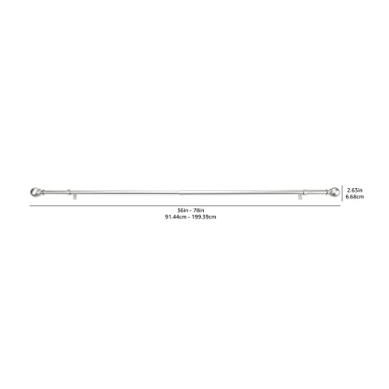

In [34]:
image_path = "..\\images\\test\\110EibNyclL.jpg"

image = cv2.imread(image_path)
display_image("Image", image, False)

In [53]:
def _process(img_path):
    # Read the image
    img = cv2.imread(img_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Use adaptive thresholding to enhance text
    enhanced_text = cv2.adaptiveThreshold(blurred, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 11, 2)

    # Sharpen the image to make text crisper
    kernel_sharpen = np.array([[-1, -1, -1],
                               [-1,  9, -1],
                               [-1, -1, -1]])
    sharpened = cv2.filter2D(enhanced_text, -1, kernel_sharpen)

    kernel = np.ones((2, 2), np.uint8)
    # To make the text thinner (erosion)
    # eroded = cv2.erode(sharpened, kernel, iterations=1)
    dilated = cv2.dilate(sharpened, kernel, iterations=1)

    return dilated

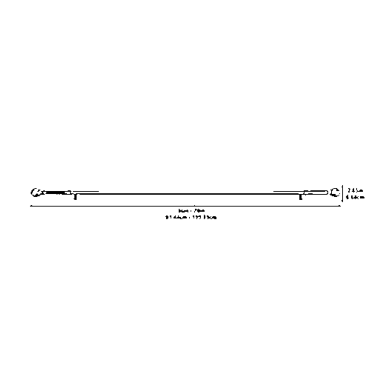

In [54]:
processed_image = _process(image_path)
display_image("processed_image", processed_image, False)

In [25]:
# message and prompt
prompt = """
Please analyze the image and provide a detailed list of all measurable properties and specifications shown, including but not limited to:

{
    length
    width
    height
    depth
    weight
    volume
    wattage
    maximum_weight_recommendation
    voltage
}
Any numerical values or measurements displayed
Any text or labels visible

Please list each property with its corresponding value and unit of measurement where applicable. If any standard properties like voltage or wattage are not depicted, simply note that they are not shown in the image. Provide the output in a JSON-like format with key-value pairs. Use the exact keys specified below. Include the unit in the value string. If a specification is not visible or applicable, use 'N/A' as the value.
"""

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {
                "type": "text",
                "text": prompt
            },
        ],
    }
]

In [26]:
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [27]:
image_inputs, video_inputs = process_vision_info(messages)

In [28]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)

inputs = inputs.to("cuda")

In [ ]:
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

In [ ]:
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

print(output_text)